In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

h08dir = '/home/kajiyama/H08/H08_20230612'
SUF = '.gl5'
dtype = 'float32'
gl5shape = (2160, 4320)
hlfshape = (360, 720)
#
tag = '.ct5'
city_num = 105
nx, ny = 36, 36
rgnshape = (ny, nx)
#
# region
one = 17
two = 20
three = -35
four = -32
upperindex = (90-four)*12
lowerindex = (90-three)*12
leftindex = (180+one)*12
rightindex = (180+two)*12
print(upperindex, lowerindex, leftindex, rightindex)

1464 1500 2364 2400


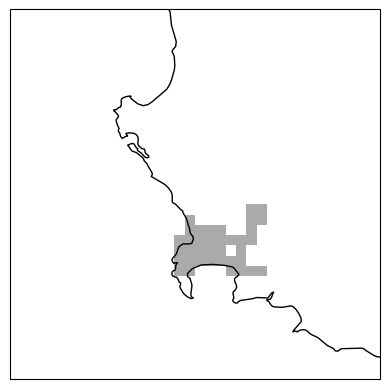

In [2]:
# city mask file
citymask = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/dat/cty_msk_/city_{city_num:08}.gl5', dtype='float32').reshape(gl5shape)

# crop
citymask_cropped = citymask[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

projection = ccrs.PlateCarree(central_longitude=0)
img_extent = (one, two, three, four)
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
im = ax.imshow(citymask_cropped, extent=img_extent, transform=projection, cmap='gray_r', vmin=0, vmax=3)

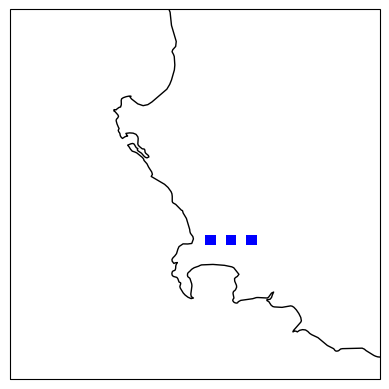

In [3]:
# intake file
josui = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/dat/cty_prf_/city_{city_num:08}.gl5', dtype='float32').reshape(gl5shape)

# crop
josui_cropped = josui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

projection = ccrs.PlateCarree(central_longitude=0)
img_extent = (one, two, three, four)
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
josui_cmap = plt.cm.colors.ListedColormap(['white', 'blue'])
im = ax.imshow(josui_cropped, extent=img_extent, transform=projection, cmap=josui_cmap)

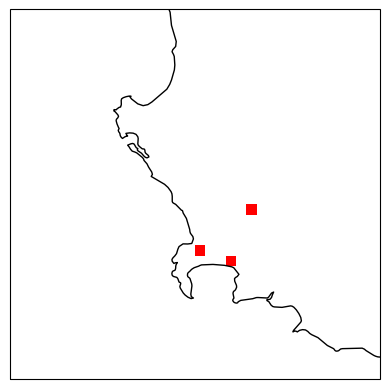

In [4]:
# gesui file
gesui = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/dat/cty_swg_/city_{city_num:08}.gl5', dtype='float32').reshape(gl5shape)

# crop
gesui_cropped = gesui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

projection = ccrs.PlateCarree(central_longitude=0)
img_extent = (one, two, three, four)
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
gesui_cmap = plt.cm.colors.ListedColormap(['white', 'red'])
im = ax.imshow(gesui_cropped, extent=img_extent, transform=projection, cmap=gesui_cmap)

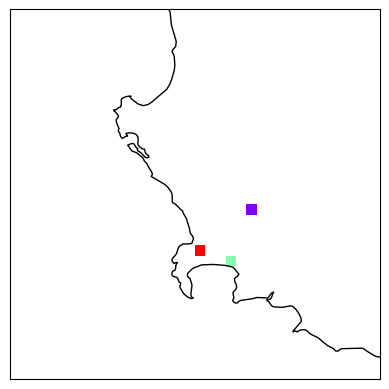

In [5]:
# rivnum file
rivnum = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/out/riv_num_/rivnum.CAMA{tag}', dtype='float32').reshape(rgnshape)

# gesui rivnum
gesui_rivnum = np.where(gesui_cropped == 1, rivnum, 0)
gesui_rivnum = np.ma.masked_where(gesui_rivnum == 0, gesui_rivnum)

projection = ccrs.PlateCarree(central_longitude=0)
img_extent = (one, two, three, four)
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
im = ax.imshow(gesui_rivnum, extent=img_extent, transform=projection, cmap='rainbow')

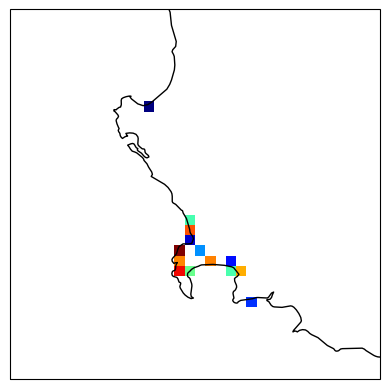

In [6]:
# rivnxl file
rivmou = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/out/riv_mou_/rivmou.CAMA{tag}', dtype='float32').reshape(rgnshape)

# rivmou rivnum
rivmou_rivnum = np.where(rivmou == 9, rivnum, 0)
rivmou_rivnum = np.ma.masked_where(rivmou_rivnum == 0, rivmou_rivnum)

projection = ccrs.PlateCarree(central_longitude=0)
img_extent = (one, two, three, four)
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
im = ax.imshow(rivmou_rivnum, extent=img_extent, transform=projection, cmap='jet')

gesui_rivnum unique_ids: [ 1528.  9205. 16344.]


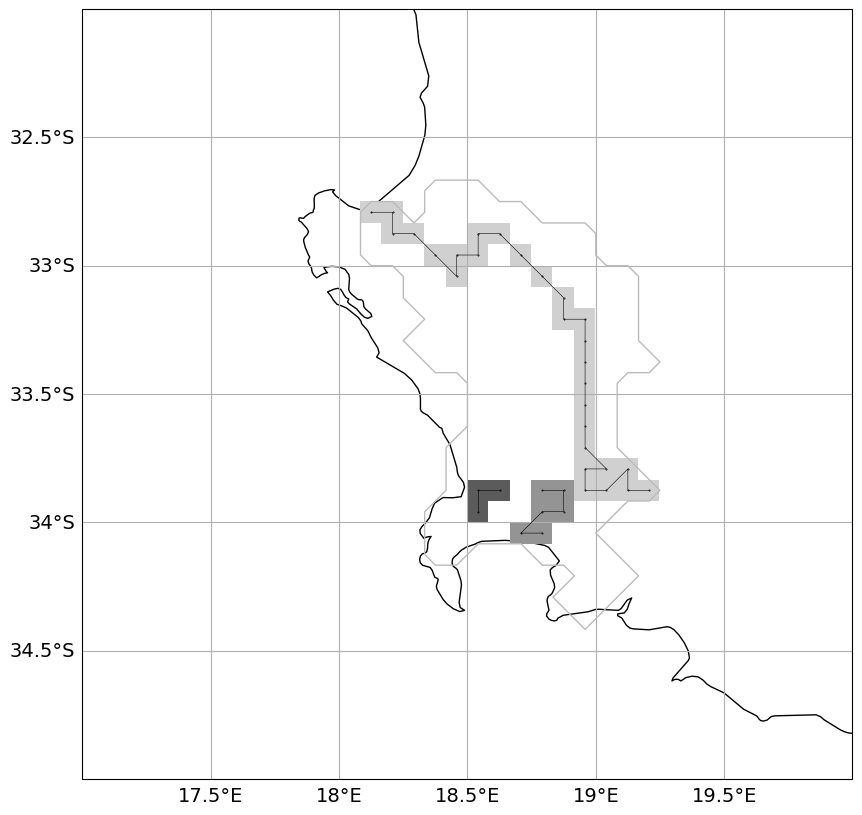

In [7]:
def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

# rivnxl file
rivmou = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/out/riv_mou_/rivmou.CAMA{tag}', dtype='float32').reshape(rgnshape)

# rivnxl file
rivnxl = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/out/riv_nxl_/rivnxl.CAMA{tag}', dtype='float32').reshape(rgnshape)

# rivara file
rivara = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/out/riv_ara_/rivara.CAMA{tag}', dtype='float32').reshape(rgnshape)

# l coordinate >>> xy coordinate
vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
result = np.empty(rivnxl.shape, dtype=tuple)
mask = ~np.isnan(rivnxl)
result[mask] = vfunc(rivnxl[mask], a=ny, b=nx)

# make result_array (48, 36, 2) with xy mesh data
result_list = []
for row in result:
    for x, y in row:
        result_list.append((x, y))
result_shape = (result.shape[0], result.shape[1], 2)
result_array = np.array(result_list).reshape(result_shape)
result_array = result_array.astype(int)

# prepare empty variables
result_dict = {}
unique_ids = np.unique(gesui_rivnum).compressed()
print(f'gesui_rivnum unique_ids: {unique_ids}')
riv_path_array = np.ma.masked_all(gesui_rivnum.shape, dtype='float32')
visited_coords = set()

# basin number loop
for uid in unique_ids:
    coords_a = np.argwhere(rivmou_rivnum == uid)
    riv_path_array[coords_a[0][0], coords_a[0][1]] = uid
    if coords_a.size > 0:
        target_coord = tuple(coords_a[0])
        path_coords = [target_coord]
        for _ in range(300):
            if target_coord in visited_coords:
                break
            visited_coords.add(target_coord)
            matched_coords = np.argwhere(np.all(target_coord == result_array, axis=2))
            if len(matched_coords) == 0:
                break
            # choose max rivara among mached indicies
            unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
            if not unvisited_matched:
                break
            rivara_values = [rivara[coord[0], coord[1]] for coord in unvisited_matched]
            max_index = np.argmax(rivara_values)
            best_coord = unvisited_matched[max_index]
            riv_path_array[best_coord[0], best_coord[1]] = uid
            target_coord = best_coord
            path_coords.append(target_coord)
        result_dict[uid] = path_coords
#
plt.rcParams["font.size"] = 14
fig = plt.figure(figsize=(10, 10))
projection = ccrs.PlateCarree()
extent = (one, two, three, four)
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.set_extent(extent, projection)
#
landmask = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/dat/lnd_msk_/lndmsk.CAMA{tag}', dtype='float32').reshape(rgnshape)
contour = ax.contour(landmask, levels=[0.5], colors='#BBBBBB', linewidths=1, origin='upper', extent=extent, transform=projection, zorder=10)
#
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfea.OCEAN, color='#FFFFFF')
ax.add_feature(cfea.LAKES, color='#FFFFFF')
#
vmin = np.min(riv_path_array) - 1e4
vmax = np.max(riv_path_array) + 1e4
img = ax.imshow(riv_path_array, extent=extent, transform=projection, cmap='Greys', vmin=vmin, vmax=vmax, zorder=2)
#
if result_dict is not None:
    for key, path in result_dict.items():
        lat_coords, lon_coords = zip(*path)

        # xy coordinate >>> lonlat coordinate
        lat_coords = [(four - lat/12 - 1/24) for lat in lat_coords]
        lon_coords = [(one + lon/12 + 1/24) for lon in lon_coords]
        ax.plot(lon_coords, lat_coords, marker='o', markersize=0.4, color='black', linestyle='-', linewidth=.4, transform=projection, zorder=5)
#
#fig.colorbar(img, ax=ax)

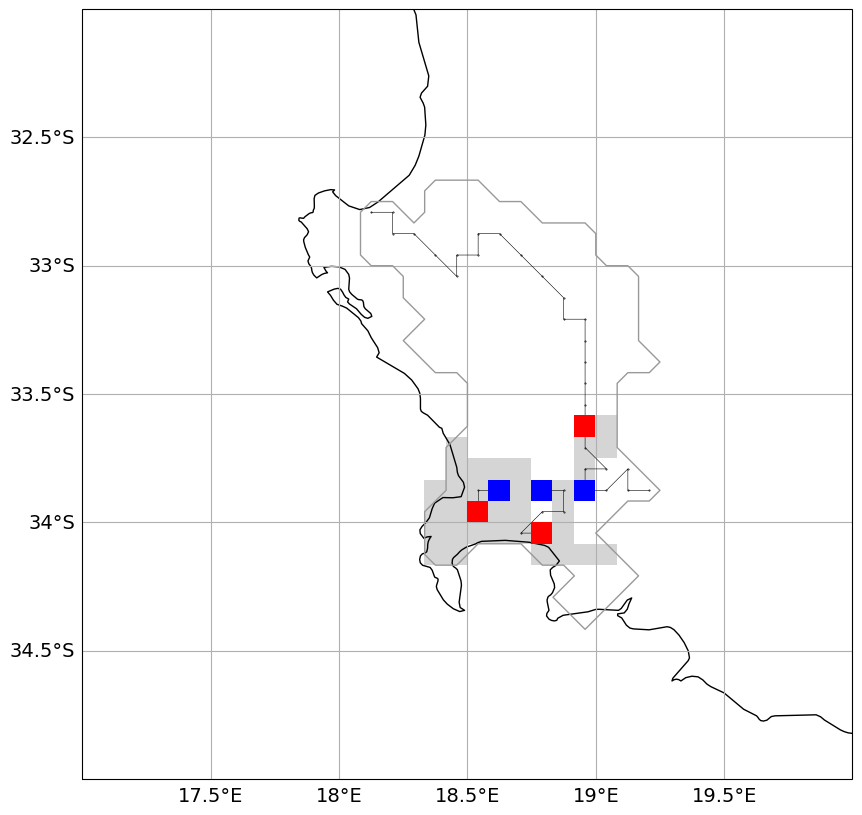

In [8]:
#
plt.rcParams["font.size"] = 14
fig = plt.figure(figsize=(10, 10))
projection = ccrs.PlateCarree()
extent = (one, two, three, four)
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.set_extent(extent, projection)
#
im1 = ax.imshow(citymask_cropped, extent=img_extent, transform=projection, cmap='gray_r', vmin=0, vmax=6)
#
landmask = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/dat/lnd_msk_/lndmsk.CAMA{tag}', dtype='float32').reshape(rgnshape)
contour = ax.contour(landmask, levels=[0.5], colors='#999999', linewidths=1, origin='upper', extent=extent, transform=projection, zorder=10)
#
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfea.OCEAN, color='#FFFFFF')
ax.add_feature(cfea.LAKES, color='#FFFFFF')
#
vmin = np.min(riv_path_array) - 1e5
vmax = np.max(riv_path_array) + 1e6
#img = ax.imshow(riv_path_array, extent=extent, transform=projection, cmap='Greys', vmin=vmin, vmax=vmax, zorder=4)
#
if result_dict is not None:
    for key, path in result_dict.items():
        lat_coords, lon_coords = zip(*path)

        # xy coordinate >>> lonlat coordinate
        lat_coords = [(four - lat/12 - 1/24) for lat in lat_coords]
        lon_coords = [(one + lon/12 + 1/24) for lon in lon_coords]
        ax.plot(lon_coords, lat_coords, marker='o', markersize=0.4, color='black', linestyle='-', linewidth=.4, transform=projection, zorder=5)
#
josui_cropped = np.ma.masked_where(josui_cropped == 0, josui_cropped)
im2 = ax.imshow(josui_cropped, extent=img_extent, transform=projection, cmap=josui_cmap, vmin=0, zorder=8)
#
gesui_cropped = np.ma.masked_where(gesui_cropped == 0, gesui_cropped)
im2 = ax.imshow(gesui_cropped, extent=img_extent, transform=projection, cmap=gesui_cmap, vmin=0, zorder=8)

0.0


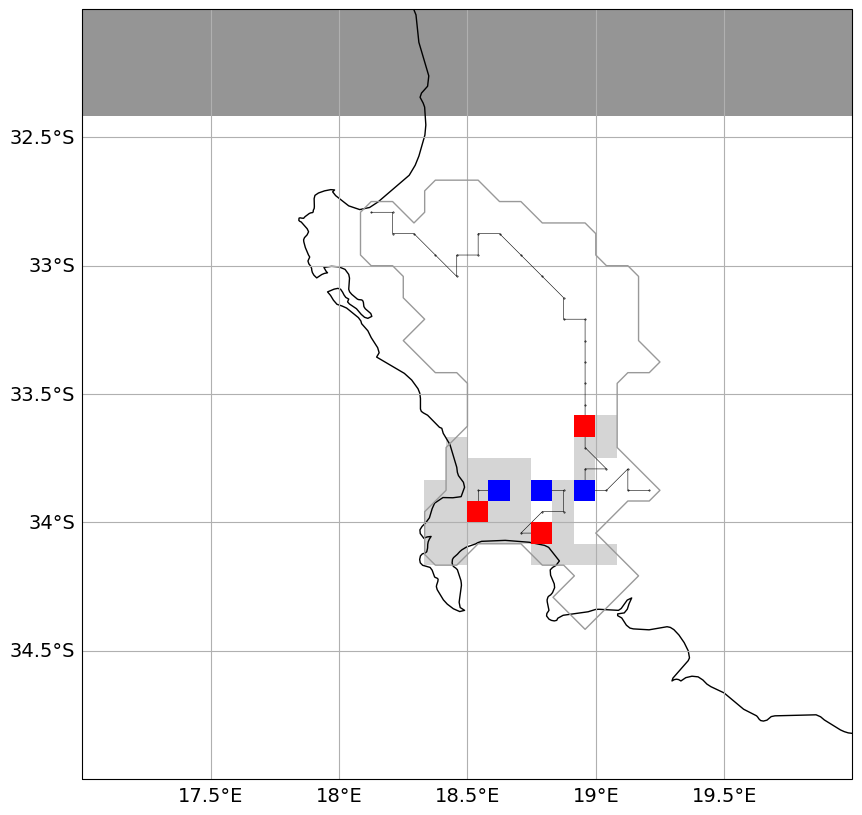

In [9]:
#
plt.rcParams["font.size"] = 14
fig = plt.figure(figsize=(10, 10))
projection = ccrs.PlateCarree()
extent = (one, two, three, four)
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.set_extent(extent, projection)
#
im1 = ax.imshow(citymask_cropped, extent=img_extent, transform=projection, cmap='gray_r', vmin=0, vmax=6)
#
landmask = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/dat/lnd_msk_/lndmsk.CAMA{tag}', dtype='float32').reshape(rgnshape)
contour = ax.contour(landmask, levels=[0.5], colors='#999999', linewidths=1, origin='upper', extent=extent, transform=projection, zorder=10)
#
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cfea.OCEAN, color='#FFFFFF')
ax.add_feature(cfea.LAKES, color='#FFFFFF')
#
vmin = np.min(riv_path_array) - 1e5
vmax = np.max(riv_path_array) + 1e6
#img = ax.imshow(riv_path_array, extent=extent, transform=projection, cmap='Greys', vmin=vmin, vmax=vmax, zorder=4)
#
if result_dict is not None:
    for key, path in result_dict.items():
        lat_coords, lon_coords = zip(*path)

        # xy coordinate >>> lonlat coordinate
        lat_coords = [(four - lat/12 - 1/24) for lat in lat_coords]
        lon_coords = [(one + lon/12 + 1/24) for lon in lon_coords]
        ax.plot(lon_coords, lat_coords, marker='o', markersize=0.4, color='black', linestyle='-', linewidth=.4, transform=projection, zorder=5)
#
josui_cropped = np.ma.masked_where(josui_cropped == 0, josui_cropped)
im2 = ax.imshow(josui_cropped, extent=img_extent, transform=projection, cmap=josui_cmap, vmin=0, zorder=8)
#
gesui_cropped = np.ma.masked_where(gesui_cropped == 0, gesui_cropped)
im2 = ax.imshow(gesui_cropped, extent=img_extent, transform=projection, cmap=gesui_cmap, vmin=0, zorder=8)
#
intake = np.fromfile(f'/home/kajiyama/H08/H08_20230612/map/dat/cty_int_/fig/intake_display_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
intake_cropped = intake[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
intake_cropped = np.ma.masked_where(intake_cropped>=1, intake_cropped)
im3 = ax.imshow(intake_cropped, extent=img_extent, transform=projection, cmap='Greys', vmin=-1, vmax=1)
print(np.max(intake_cropped))